### Created by: Anthony D. Cho
### Last update: 20.12.2021

**Subject**: Regression (Keras - Tensorflow) - Applied to QSAR fish toxicity


## Libraries dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from pandas import read_csv

## Pre-processing functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Keras from tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

## Customized function

In [2]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    History performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()

# Problem: QSAR fish toxicity

**Target**: Predict LC50 (Lethal Concentration of 50%)

## Data loading

Source: [QSAR fish toxicity](https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity)

In [3]:
## Load data
data = read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00504/qsar_fish_toxicity.csv', 
                sep=';', header=None)

data.columns = ['CIC0', 'SM1_Dz(Z)', 'GATS1i', 'NdsCH', 'NdssC', 'MLOGP', 'LC50']

In [4]:
## Data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CIC0       908 non-null    float64
 1   SM1_Dz(Z)  908 non-null    float64
 2   GATS1i     908 non-null    float64
 3   NdsCH      908 non-null    int64  
 4   NdssC      908 non-null    int64  
 5   MLOGP      908 non-null    float64
 6   LC50       908 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 49.8 KB


In [5]:
## data description
data.describe(include='all')

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50
count,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000
mean,2.898129,0.628468,1.293591,0.229075,0.485683,2.109285,4.064431
std,0.756088,0.428459,0.394303,0.605335,0.861279,1.433181,1.455698
min,0.667000,0.000000,0.396000,0.000000,0.000000,-2.884000,0.053000
25%,2.347000,0.223000,0.950750,0.000000,0.000000,1.209000,3.151750
50%,2.934000,0.570000,1.240500,0.000000,0.000000,2.127000,3.987500
75%,3.407000,0.892750,1.562250,0.000000,1.000000,3.105000,4.907500
max,5.926000,2.171000,2.920000,4.000000,6.000000,6.515000,9.612000


In [6]:
data.head(4)

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510


## Data pre-processing

In [7]:
## Partition sets
X_train, X_test = train_test_split(data, random_state=20200803)

## Standardizing
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

## Predictors and target assignment
y_train = X_train[:, 6]
y_test = X_test[:, 6]
X_train = X_train[:, :6]
X_test = X_test[:, :6]

## Display shape of data
print('(train shape) X: {}, y: {}'.format(X_train.shape, y_train.shape))
print('(test shape) X: {}, y: {}'.format(X_test.shape, y_test.shape))

(train shape) X: (681, 6), y: (681,)
(test shape) X: (227, 6), y: (227,)


## Model building

In [8]:
## Model instance
model = Sequential(name='Regression')
model.add(layers.Dense(units=32, 
                       activation='relu', 
                       input_shape=(X_train.shape[1],), 
                       name='HiddenLayer_1'))
model.add(layers.Dense(units=16, 
                       activation='relu',
                       name='HiddenLayer_2'))
model.add(layers.Dense(units=1, 
                       name='output'))

## Display model
model.summary()

Model: "Regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HiddenLayer_1 (Dense)        (None, 32)                224       
_________________________________________________________________
HiddenLayer_2 (Dense)        (None, 16)                528       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [9]:
start = time()

## Compiler setting
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

## model fitting
history = model.fit(x=X_train, y=y_train, 
                    validation_split=0.15,
                    epochs=50, 
                    batch_size=10)

stop = time()
print('Time spent[s]: {:2f}'.format(stop -start))

Epoch 1/50
58/58 [==============================] - 1s 10ms/step - loss: 0.7337 - mse: 0.9741 - val_loss: 0.5001 - val_mse: 0.3739
Epoch 2/50
58/58 [==============================] - 0s 2ms/step - loss: 0.4909 - mse: 0.4899 - val_loss: 0.4238 - val_mse: 0.2806
Epoch 3/50
58/58 [==============================] - 0s 2ms/step - loss: 0.4387 - mse: 0.3937 - val_loss: 0.4092 - val_mse: 0.2789
Epoch 4/50
58/58 [==============================] - 0s 2ms/step - loss: 0.4168 - mse: 0.3621 - val_loss: 0.4008 - val_mse: 0.2742
Epoch 5/50
58/58 [==============================] - 0s 2ms/step - loss: 0.4444 - mse: 0.4120 - val_loss: 0.3997 - val_mse: 0.2583
Epoch 6/50
58/58 [==============================] - 0s 2ms/step - loss: 0.4030 - mse: 0.3235 - val_loss: 0.3926 - val_mse: 0.2626
Epoch 7/50
58/58 [==============================] - 0s 2ms/step - loss: 0.4256 - mse: 0.3558 - val_loss: 0.4038 - val_mse: 0.2703
Epoch 8/50
58/58 [==============================] - 0s 2ms/step - loss: 0.4178 - mse: 0.3

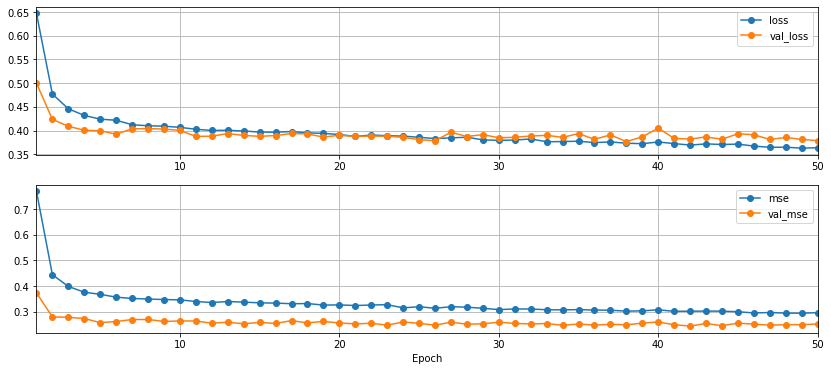

8/8 [==============================] - 0s 1ms/step - loss: 0.5159 - mse: 0.5595


In [11]:
plot_history(history, width=14)

## Compute model evaluation using test set
model.evaluate(X_test, y_test)

## Compute prediction using test set.
prediction = model.predict(X_test)

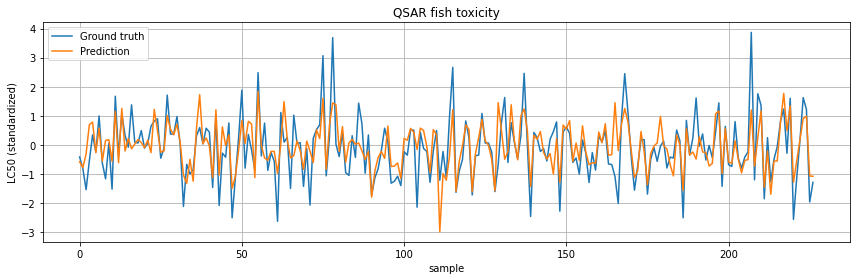

In [24]:
## Display prediction and ground truth
plt.figure(figsize=(12, 4))
plt.plot(y_test, label='Ground truth')
plt.plot(prediction, label='Prediction')
plt.xlabel('sample'); plt.ylabel('LC50 (standardized)')
plt.title('QSAR fish toxicity')
plt.legend(); plt.grid()
plt.tight_layout()
plt.show()


## Best model

Looking into the performance charts, it seems to stabilize (kind of overfit) starting at epoch 26.

In [19]:
## Model instance
model = Sequential(name='Regression')
model.add(layers.Dense(units=32, 
                       activation='relu', 
                       input_shape=(X_train.shape[1],), 
                       name='HiddenLayer_1'))
model.add(layers.Dense(units=16, 
                       activation='relu',
                       name='HiddenLayer_2'))
model.add(layers.Dense(units=1, 
                       name='output'))

## Display model
model.summary()

Model: "Regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HiddenLayer_1 (Dense)        (None, 32)                224       
_________________________________________________________________
HiddenLayer_2 (Dense)        (None, 16)                528       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [20]:
start = time()

## Compiler setting
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

## model fitting
history = model.fit(x=X_train, y=y_train, 
                    epochs=26, 
                    batch_size=10)

stop = time()
print('Time spent[s]: {:2f}'.format(stop -start))

Epoch 1/26
69/69 [==============================] - 0s 2ms/step - loss: 0.6915 - mse: 0.8383
Epoch 2/26
69/69 [==============================] - 0s 2ms/step - loss: 0.4790 - mse: 0.4398
Epoch 3/26
69/69 [==============================] - 0s 1ms/step - loss: 0.4424 - mse: 0.3814
Epoch 4/26
69/69 [==============================] - 0s 1ms/step - loss: 0.4307 - mse: 0.3521
Epoch 5/26
69/69 [==============================] - 0s 1ms/step - loss: 0.4327 - mse: 0.3858
Epoch 6/26
69/69 [==============================] - 0s 2ms/step - loss: 0.4176 - mse: 0.3592
Epoch 7/26
69/69 [==============================] - 0s 1ms/step - loss: 0.4157 - mse: 0.3533
Epoch 8/26
69/69 [==============================] - 0s 1ms/step - loss: 0.4023 - mse: 0.3348
Epoch 9/26
69/69 [==============================] - 0s 2ms/step - loss: 0.4040 - mse: 0.3465
Epoch 10/26
69/69 [==============================] - 0s 1ms/step - loss: 0.3624 - mse: 0.2751
Epoch 11/26
69/69 [==============================] - 0s 1ms/step - lo

In [21]:
## Compute prediction using test set.
prediction = model.predict(X_test)

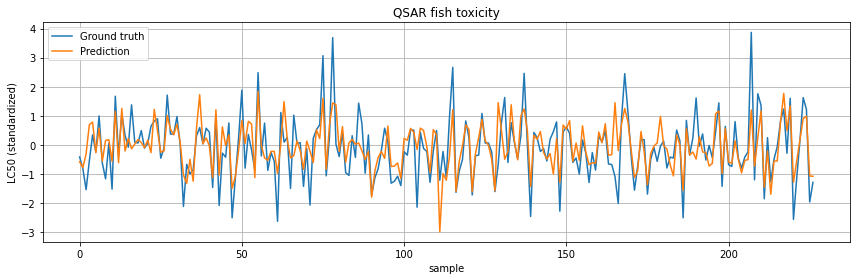

In [23]:
## Display prediction and ground truth
plt.figure(figsize=(12, 4))
plt.plot(y_test, label='Ground truth')
plt.plot(prediction, label='Prediction')
plt.xlabel('sample'); plt.ylabel('LC50 (standardized)')
plt.title('QSAR fish toxicity')
plt.legend(); plt.grid()
plt.tight_layout()
plt.show()